Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


=== Posterior Summary: First Experiment ===


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.669,0.129,0.443,0.906,0.003,0.002,1770.0,2231.0,1.0


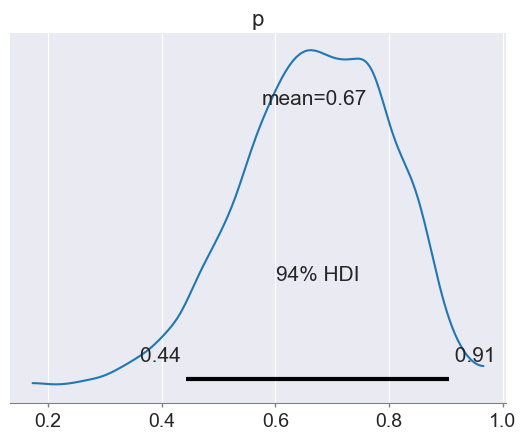

In [17]:
# =========================
# Cell 1: First experiment
# =========================
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

# Datele din primul experiment: s, b, b, b, s, b, s, b, b, b
data1 = np.array([0,1,1,1,0,1,0,1,1,1])

with pm.Model() as model1:
    # Prior Beta(1,1)
    p = pm.Beta('p', alpha=1, beta=1)

    # Likelihood: Bernoulli observat
    obs = pm.Bernoulli('obs', p=p, observed=data1)

    # Sampling
    trace1 = pm.sample(1000, random_seed=42, return_inferencedata=True)

# Rezumat și grafic a posteriori
print("=== Posterior Summary: First Experiment ===")
display(az.summary(trace1, var_names=['p']))
az.plot_posterior(trace1, var_names=['p'])
plt.show()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


=== Posterior Summary: Second Experiment (with uniform prior) ===


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.5,0.136,0.254,0.76,0.003,0.002,1766.0,2332.0,1.0


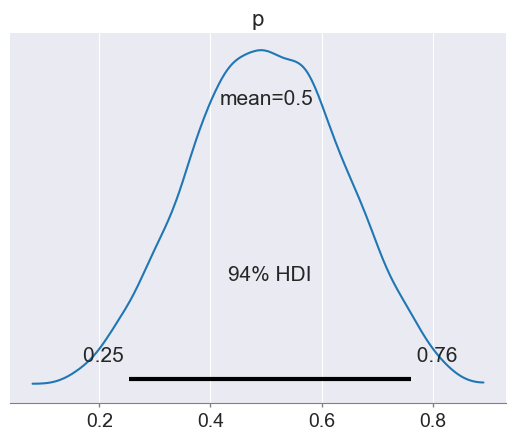

In [18]:
# ==========================
# Cell 2: Second experiment
# ==========================
# Datele din al doilea experiment: s, s, b, s, b, b, s, b, b, s
data2 = np.array([0,0,1,0,1,1,0,1,1,0])

with pm.Model() as model2:
    # Prior Beta(1,1)
    p = pm.Beta('p', alpha=1, beta=1)

    # Likelihood: Bernoulli observat
    obs = pm.Bernoulli('obs', p=p, observed=data2)

    # Sampling
    trace2 = pm.sample(1000, random_seed=42, return_inferencedata=True)

# Rezumat și grafic a posteriori
print("=== Posterior Summary: Second Experiment (with uniform prior) ===")
display(az.summary(trace2, var_names=['p']))
az.plot_posterior(trace2, var_names=['p'])
plt.show()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


=== Posterior Summary: Second Experiment (with Beta(8,4) prior) ===


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.594,0.102,0.413,0.791,0.003,0.002,1438.0,2409.0,1.0


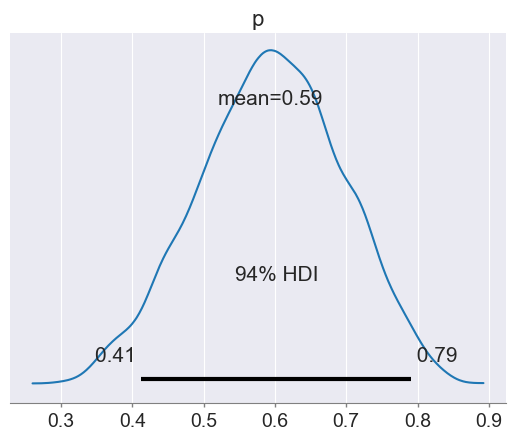

In [19]:
# ====================================================
# Cell 3: Second experiment, but prior = Beta(8,4)
# ====================================================
with pm.Model() as model3:
    # Prior = Beta(8,4), care a fost posteriorul anterior
    p = pm.Beta('p', alpha=8, beta=4)

    # Likelihood: Bernoulli cu a doua secvență
    obs = pm.Bernoulli('obs', p=p, observed=data2)

    # Sampling
    trace3 = pm.sample(1000, random_seed=42, return_inferencedata=True)

# Rezumat și grafic a posteriori
print("=== Posterior Summary: Second Experiment (with Beta(8,4) prior) ===")
display(az.summary(trace3, var_names=['p']))
az.plot_posterior(trace3, var_names=['p'])
plt.show()
